In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import os

from astropy.io import fits
from skimage.filters import threshold_otsu
from scipy.ndimage import shift
from scipy.signal import correlate

In [2]:
'''Help


# ---------------------------------------- Переменные -----------------------------------------------------------------
nx - ширина окна для автокорреляции зрачка, должно быть минимум в 2 раза больше, чем ширина зрачка [pix]
I0c - индикатор для зрачка  
f_scale - шаг по частоте, [м^-1]
delta - шаг апертуры или же просто размер 1ого пикселя, [м] 

def frequency_dim - создание пространства частот 
def c_jk - создание коэффициента передачи зрачка
def move_gamma - сдвиг гаммы относительно центра взависимости от скорости ветра
# ---------------------------------------------------------------------------------------------------------------------

Ex:

Для примера пусть Cn2 соответствует качеству изображения, равному 1 угловой секунде (типичное качество изображения) на длине 
волны 500 нм. Для удобства величину Cn2(z)dz рассматриваем как одну величину, обозначим ее C. Тогда:
    beta = 0.98 * lambda/r0 = 1, следовательно: r0 = 0.98*lambda*206265,
Пусть мы наблюдаем в зените, тогда параметр Фрида будет:
    r0 = (0.423*k^2 * C)^(-3/5), где k = 2*pi/lambda.
Далее можно просто выразить и посчитать С
    Cn2_ex = pow((0.98*lambda_)*206265, -5/3) / (0.423*pow(2*np.pi/lambda_, 2))
    
А вообще, нам неважно какое значение Cn2 брать, ответ всегда будет верным
# ---------------------------------------------------------------------------------------------------------------------

Подложки на изображении-результате кросс-корреляции быть не должно (ее видно если брать модуль от мнимой части). Видно, 
что значения мнимой части очень маленькие, поэтому можно выводить сразу действительную часть.
Черные области рядом с пиками - зоны Френеля. По радиусу этих зон можно посчитать дистанцию распространения
'''
print()

In [18]:
# --- апертурный фильтр
def aperture_func(nx, f_scale, delta): 
    fx, fy = f_scale * np.asarray(np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx)))
    res = np.abs(np.sinc(delta*fx)*np.sinc(delta*fy))**2
    res[np.isnan(res)] = 0
    return res
    
# --- модуль |f|^11/3 
def abs_f(nx, f_scale):
    fx, fy = f_scale * np.asarray(np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx)))
    with np.errstate(divide='ignore'):
        res = pow(np.sqrt(fx**2+fy**2), -11./3.)
    
    res[np.isnan(res)] = 0
    return res

# --- фильтр Френеля
def ffilter(nx, f_scale, z, lambda_): 
    fx, fy = f_scale * np.asarray(np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx)))
    res = pow(np.sin(np.pi*z*lambda_*(fx**2+fy**2)), 2) / pow(lambda_, 2)
    res[np.isnan(res)] = 0
    return res

# --- автокорреляция зрачка
def c_jk(nx, frame):
    I0c = (frame != 0) * int(1)
    res = correlate(I0c, I0c, mode='full', method='fft')
    res = res / np.sum(frame!=0)

    tmp = np.zeros((res.shape[0]+1, res.shape[1]+1))
    tmp[1:,1:] = res
    return tmp

# --- спектральный фильтр
def sfilter(nx, f_scale, z, D=None, resp_f=None):    
    # oversampling 
    coeff = 1000
    k = 1071*coeff
    lambda_max = int((len(resp_f)-1)*coeff)
    lambdas = np.linspace(0, lambda_max, k) * pow(10, -9) # [м]
    tail = np.zeros((len(lambdas) - len(resp_f)))
    resp_f = np.append(resp_f, tail)
    
    res_fft = pow((np.imag(np.fft.fft(resp_f/lambdas))), 2)

    delta_lambdas = (lambda_max / len(lambdas)) * pow(10, -9) # период дискретизации, шаг по частоте [м]
    omega_lambdas_scale = 1 / (delta_lambdas) # максимальное значение по частоте, [м^-1]

    fx, fy = f_scale * np.asarray(np.meshgrid(np.linspace(-nx//2, nx//2-1, nx), np.linspace(-nx//2, nx//2-1, nx)))
    f_abs = np.sqrt(pow(fx, 2) + pow(fy, 2))

    omega = 0.5 * z * pow(f_abs, 2) # аргумент, шаг по частоте, [м^-1]
    omega = np.ravel(omega)
    omega_new = np.interp(omega, np.linspace(0, omega_lambdas_scale, k), res_fft)
    omega_new = np.resize(omega_new, (nx, nx))
    
    plt.figure()
    plt.imshow(omega_new)
    plt.colorbar()
    return omega_new

# --- монохроматическая гамма
def gamma_mono(Vx, Vy, Cn2, z, lambda_, frame=None, D=None, sec_per_frame=None, latency=None):
    const = 9.69*pow(10, -3)*16*pow(np.pi, 2)
    nx=2*frame.shape[0]
    f_scale = 1/(2*D)
    delta = D/(2*frame.shape[0])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! убрать 2

    t = sec_per_frame * latency
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta

    Fresnel_filter = ffilter(nx, f_scale, z, lambda_)
    f_11_3 = abs_f(nx, f_scale)
    A_f = aperture_func(nx, f_scale, delta) 
    
    with np.errstate(invalid='ignore'):
        res = f_11_3 * Fresnel_filter
    
    res[np.isnan(res)] = 0
    res = res * A_f
    res[np.isnan(res)] = 0
    
    res = np.fft.fftshift(np.fft.irfft2(np.fft.fftshift(res), s=res.shape, norm='backward'))
    res = res * 9.69*pow(10, -3)*16*pow(np.pi, 2)

    res = res * pow(f_scale*nx, 2)
    res = Cn2 * res   
    res = shift(res, (-Ypix, Xpix), order=1)
    
    cjk = c_jk(nx, frame)
    res = res * cjk
    return res

# --- полихроматическая гамма
def gamma_poly(Vx, Vy, Cn2, z, frame=None, D=None, sec_per_frame=None, latency=None, resp_f=None):
    nx=2*frame.shape[0]
    f_scale = 1/(2*D)
    delta = D/(2*frame.shape[0])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! убрать 2

    t = sec_per_frame * latency
    Lx = Vx*t
    Ly = Vy*t
    Xpix = Lx/delta
    Ypix = Ly/delta
     
    Spectral_filter = sfilter(nx, f_scale, z, D=D, resp_f=resp_f)
    f_11_3 = abs_f(nx, f_scale) 
    A_f = aperture_func(nx, f_scale, delta) 
  
    with np.errstate(invalid='ignore'):
        res = f_11_3 * Spectral_filter
    
    res[np.isnan(res)] = 0
    res = res * A_f
    res[np.isnan(res)] = 0
    
    res = np.fft.fftshift(np.fft.irfft2(np.fft.fftshift(res), s=res.shape, norm='backward'))
    res = res * 9.69*pow(10, -3)*16*pow(np.pi, 2)

    res = res * pow(f_scale*nx, 2)
    res = Cn2 * res   
    res = shift(res, (-Ypix, Xpix), order=1)
    
    cjk = c_jk(nx, frame)
    res = res * cjk
    return res
 
# --- кросс-корреляция
def correlate1(frames, image_binary, latency): 
    def correlate_fft(img1, img2):
#         corr = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(img1)*np.fft.fft2(img2).conjugate()))) # np.real; np.abs
        corr = correlate(img1, img2, mode='full', method='fft')
        return corr

    correlation = [correlate_fft(frames[i], frames[i + latency]) for i in range(frames.shape[0] - latency)]
    res = np.mean(correlation, axis=0)
    res /= np.sum(image_binary)
    
    tmp = np.zeros((res.shape[0]+1, res.shape[1]+1))
    tmp[1:,1:] = res
    return tmp 
    
# --- получение чистого изображения зрачка
def pupil(images, latency): 
    def image_square_cropp(images): 
        mask = images[np.random.randint(images.shape[0])] != 0
        rows = np.flatnonzero((mask.any(axis=1))) 
        cols = np.flatnonzero((mask.any(axis=0)))
        res = images[:, rows.min():rows.max()+1, cols.min():cols.max()+1]
        return res 
    
    def image_flatten(image): 
        if image.shape[1] > image.shape[2]:
            image = image[:,0:image.shape[1]-1,:]
        if image.shape[1] < image.shape[2]:
            image = image[:,:,0:image.shape[2]-1]        
        # добавить так же случай, если получится квадратное но нечетное изображение
        return image
    
    image_average = np.mean(images, axis=0) # средний кадр серии
    image_binary = (image_average > threshold_otsu(image_average)*int(1)) # маска среднего кадра
    images_norm = [(i/(image_average))*(np.sum(image_average)/np.sum(i)) - 1 for i in images] # нормировка изображений
    images_clean = images_norm * image_binary # отделение зрачка от фона
    images_clean[np.isnan(images_clean)] = 0
    
    images_clean = image_square_cropp(images_clean) # обрезка зрачка в квадрат
    images_clean = image_flatten(images_clean) # подгонка размера изображения под квадратное
    
    varrr = []
#     a = int(2*images_clean.shape[1]+1 - images_clean.shape[1])//2
#     b = int(2*images_clean.shape[2]+1 - images_clean.shape[2])//2
#     images_clean = np.pad(images_clean, ((0, 0), (a, a), (b, b)), 'constant', constant_values=(0)) # дополнение изображения
#     # до размера автокорреляции
    
    cross_corr = correlate1(images_clean, image_binary, latency)
    res = images_clean[np.random.randint(images_clean.shape[0])]
    return res, cross_corr  

# --- считывание файлов
def run(file, file_bias=None, latency=None):    
    st = time.perf_counter() 
    with fits.open(file_bias) as f:
        f.info()
        bias = np.mean(f[0].data, axis=0, dtype=np.float32)
    
    with fits.open(file) as f:
        f.info()
        header = f[0].header
#         if header['FRATE']:
#             sec_per_frame = 1 / f[0].header['FRATE']
#         else:
        sec_per_frame = 0.01
        data = np.float32(f[0].data)
        data -= bias
        frame, data_corr = pupil(data, latency)
  
    print('time:', time.perf_counter()-st)
    return frame, data_corr, sec_per_frame

Filename: bias20210130.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 1000)   int16 (rescales to uint16)   
Filename: 20210130l_m2km.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (329, 246, 6000)   int16 (rescales to uint16)   
time: 127.2751425

pupil image shape: (226, 226)
cross corr image shape: (452, 452)
cross corr latency: 4
max cross corr value: (226, 226) 0.020219190046191216
min cross corr value: (240, 199) -0.0036408561281859875


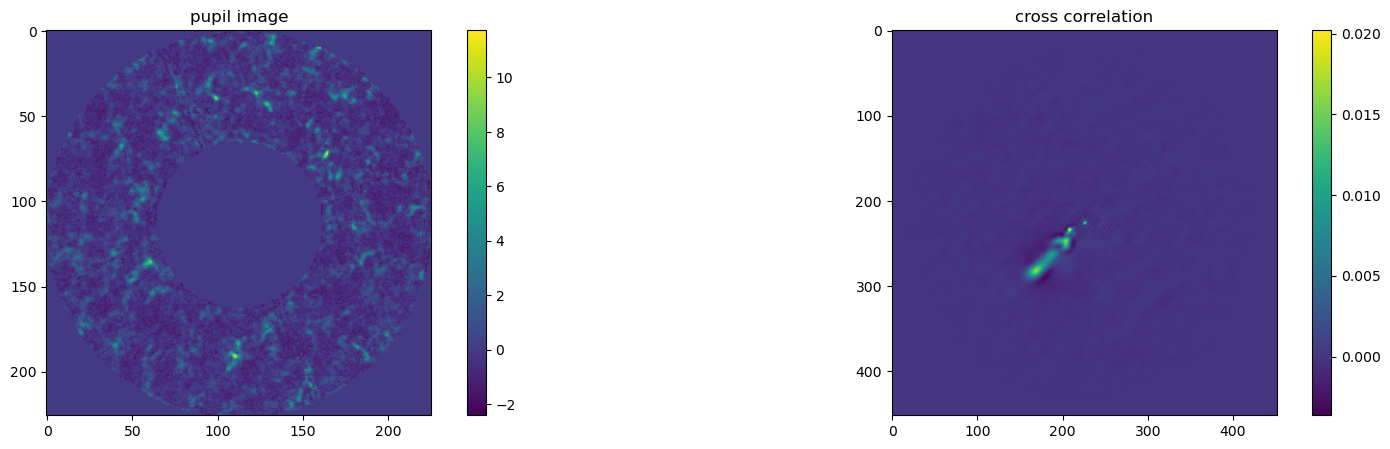

In [4]:
file = '20210130l_m2km.fits'  # 'lol_m2km.fits'
file_bias = 'bias20210130.fits'  
resp_f = np.loadtxt('C:/astro/domecam/resp_f.gz') 
latency = 4         
pupil_diameter = 2.5

frame, data_corr, sec_per_frame = run(file, file_bias=file_bias, latency=latency)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))

fig.colorbar(ax.imshow(frame), ax = ax)
ax.set_title(f'pupil image')

fig.colorbar(ax2.imshow(data_corr), ax = ax2)
ax2.set_title(f'cross correlation')

np.savetxt(f'C:/astro/domecam/data_corr{latency}.gz', data_corr)
np.savetxt('C:/astro/domecam/frame.gz', frame)
print('')
print('pupil image shape:', frame.shape)
print('cross corr image shape:', data_corr.shape)
print('cross corr latency:', latency)
print('max cross corr value:', np.unravel_index(np.argmax(data_corr), data_corr.shape), np.max(data_corr))
print('min cross corr value:', np.unravel_index(np.argmin(data_corr), data_corr.shape), np.min(data_corr))

In [5]:
# a1 = np.linspace(0, 50000, 100)
# np.savetxt('C:/astro/domecam/z.gz', a1)
# print(a1[0], a1[-1])



# gammas = np.ndarray(shape=(len(a1), cjk.shape[0], cjk.shape[1]))
# for i in range(len(a1)):
#     gammas[i] = gamma_poly(X, Y, 0, 0, 1e-13, a1[i])
# print('Done!')
# np.save(f'C:/astro/domecam/gammas.npy', gammas)
# del gammas
# gammas = np.load(f'C:/astro/domecam/gammas.npy')
# print(gammas.shape)

In [6]:
print(np.var(frame))
mask = frame!=0
a = np.sum(frame!=0)

print(np.var(frame, where=(mask==1)))

res = np.fft.fftshift(np.real(np.fft.ifft2(np.fft.fft2(frame)*np.fft.fft2(frame).conjugate()))) # np.real; np.abs
res = res / a
#res = res / res.size

print(np.var(frame, where=(mask==1))*(a/frame.size))
print(np.max(res))


mono = gamma_mono(0, 0, 1e-13, 2000, 6.5e-7, frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency)
print(np.max(mono))

# вот это тоже интересный момент с проверкой значений. типа значение автокорреляции в 0 равно значению дисперсии зрачка
# без учета нулевых значений

0.5754335
0.8932292
0.5754329460753337
0.8932312671561268
0.014853766887197476


C:\Users\miron\AppData\Local\Temp\ipykernel_8932\3005223866.py:44: RuntimeWarning: invalid value encountered in true_divide
  res_fft = pow((np.imag(np.fft.fft(resp_f/lambdas))), 2)


0.01431 0.01636 0.01630 0.01676


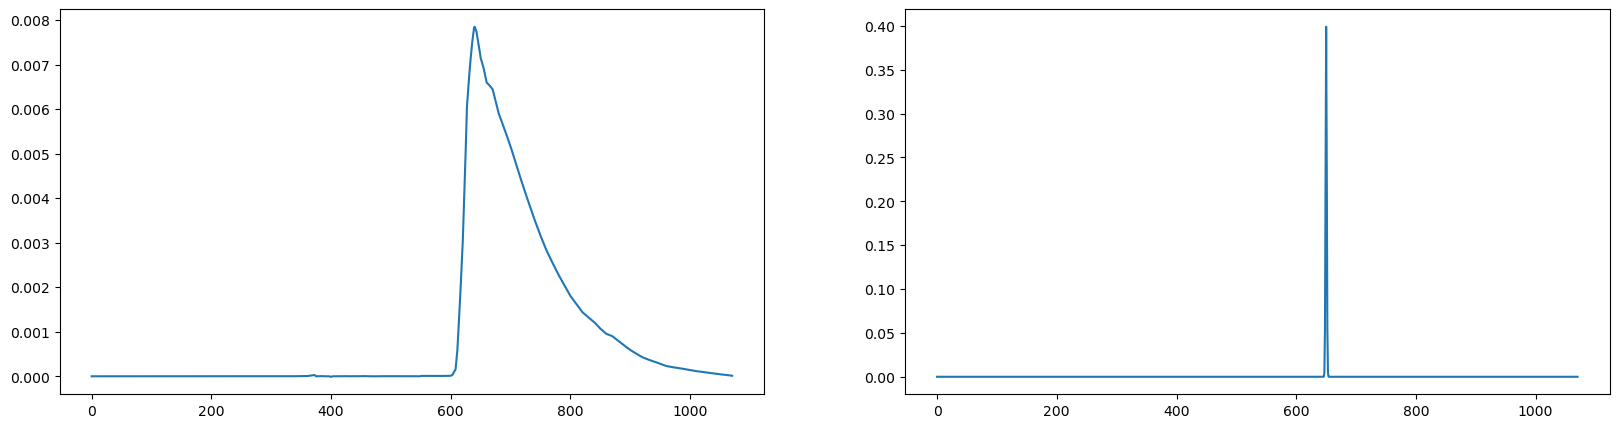

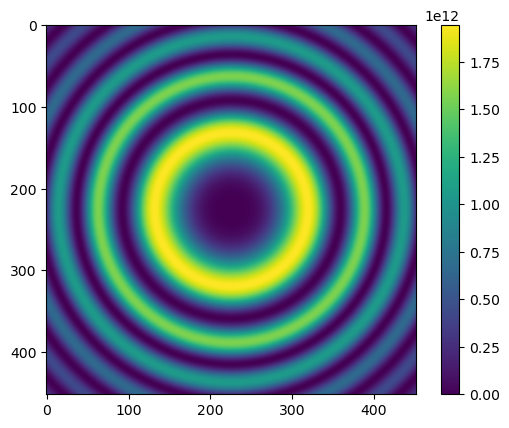

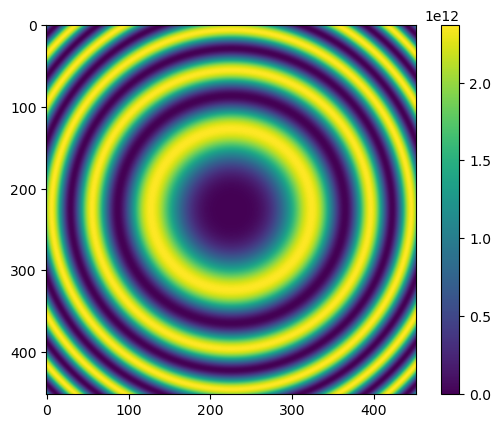

In [23]:
from scipy.stats import norm
import statistics

y = norm.pdf(range(1071), 650, 1)

fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 5))

ax.plot(resp_f)
ax2.plot(y)

poly1 = gamma_poly(0, 0, 1e-13, 1994, 
                   frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency, resp_f=resp_f)
poly2 = gamma_poly(0, 0, 1e-13, 1994, 
                   frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency, resp_f=y)
mono = gamma_mono(0, 0, 1e-13, 1994, 6.5e-7,
                   frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency)


print(f'{np.max(poly1):.5f} {np.max(poly2):.5f} {np.max(mono):.5f} {0.0167601:.5f}')


# добавить в отчет табличку со сравнением этих значений, типа указать, что мы проверили все это

# а сами значения были получены путем численного подсчета интеграла, путем зануления j и k

C:\Users\miron\AppData\Local\Temp\ipykernel_8932\672536540.py:44: RuntimeWarning: invalid value encountered in true_divide
  res_fft = pow((np.imag(np.fft.fft(resp_f/lambdas))), 2)


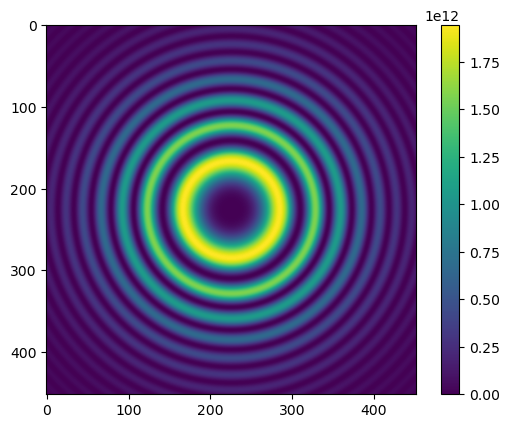

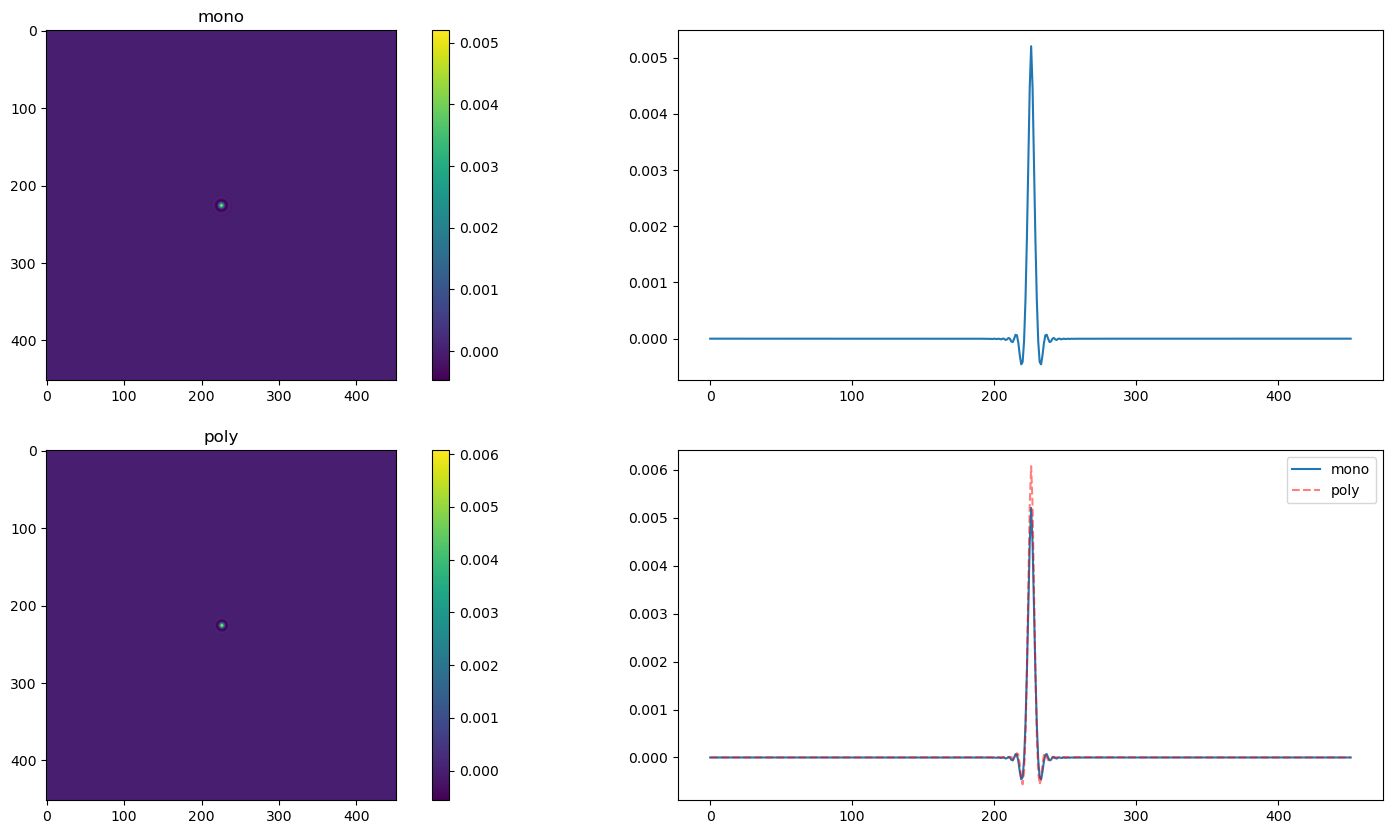

In [8]:
Vx=0
Vy=0

mono = gamma_mono(Vx, Vy, 2e-14, 5000, 8.5e-7,
                   frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency)
poly = gamma_poly(Vx, Vy, 2e-14, 5000, 
                   frame=frame, D=pupil_diameter, sec_per_frame=sec_per_frame, latency=latency, resp_f=resp_f)

fig, ((ax, ax3), (ax2, ax4)) = plt.subplots(2, 2, figsize=(20, 10))

fig.colorbar(ax.imshow(mono), ax = ax)
ax.set_title('mono')
ax3.plot(range(452), mono[226, :])

fig.colorbar(ax2.imshow(poly), ax = ax2)
ax2.set_title('poly')
ax4.plot(range(452), mono[226, :], label='mono')
ax4.plot(range(452), poly[226, :], color='red', ls='--', alpha=0.5, label='poly')
ax4.legend()

In [9]:
# '''Отрисовка подкупольной турбулентности'''

# def dome_turbulence(speckle_coords=None, data_corr=None, type_='mono', lambda_=None):
#     global X, Y, corr_latency
#     Cn2_ex = 1*pow(10, -13)
#     Vx = 0
#     Vy = 0
#     x = speckle_coords[1]
#     y = speckle_coords[0]
#     if type_ == 'mono':
#         input_lambda = lambda_
#         k = data_corr[y, x] / np.max((gamma_mono(X, Y, Vx, Vy, Cn2_ex, z, input_lambda)))
#         Cn2 = Cn2_ex * k 
#         gamma_new = gamma_mono(X, Y, Vx, Vy, Cn2, z, input_lambda)
#         tit = 'Dome turbulence, monochromatic scintillation'
        
#     if type_ == 'poly':
#         k = data_corr[y, x] / np.max((gamma_poly(X, Y, Vx, Vy, Cn2_ex, z)))
#         Cn2 = Cn2_ex * k 
#         gamma_new = gamma_poly(X, Y, Vx, Vy, Cn2, z) 
#         tit = 'Dome turbulence, polychromatic scintillation'
        

#     centr = np.unravel_index(np.argmax(gamma_new), gamma_new.shape)

#     X1 = data_corr[:, data_corr.shape[1]//2]
#     Y1 = range(data_corr.shape[0])
#     X3 = gamma_new[centr[0]-data_corr.shape[0]//2-1:centr[0]+data_corr.shape[0]//2, gamma_new.shape[1]//2]
#     Y3 = range(data_corr.shape[0])

#     fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(30, 5))
#     fig.colorbar(ax.imshow(data_corr[y-40:y+40, x-40:x+40]), ax = ax)
#     ax.scatter(x=data_corr[y-40:y+40, x-40:x+40].shape[1]//2, y=data_corr[y-40:y+40, x-40:x+40].shape[0]//2, 
#                label='Dome turbulence', alpha=0.5, s=30, color='red')
#     ax.legend()
#     ax.grid(False)

#     fig.colorbar(ax2.imshow(gamma_new[centr[0]-40:centr[0]+40, 
#                                       centr[1]-40:centr[1]+40]), ax=ax2)
#     ax2.grid(False)

#     ax3.plot(X1, Y1, alpha = 1, label = 'original corr', color = 'black')
#     ax3.plot(X3, Y3, alpha = 0.7, ls = '--', label = 'corected gamma', color = 'red')
#     ax3.legend(['Data', 'Speckle model'], loc=1, prop={'size': 12})
#     ax3.grid(color = 'black', linestyle='--', alpha = 0.2)
#     fig.colorbar(ax4.imshow(data_corr[y-40:y+40, x-40:x+40] - gamma_new[centr[0]-40:centr[0]+40, centr[1]-40:centr[1]+40]),
#                 ax=ax4)

#     ax.set_title('Data')
#     ax2.set_title('Speckle model')
#     ax3.set_title('Comparison')
#     ax4.set_title('Residuals')
#     fig.text(0.15, -0.05, f'{tit}\n\
# latency: {corr_latency}\n\
# Cn2 value: {Cn2}')
#     print(tit)
#     print('Cn2 value:', Cn2)

# lambda_ = 500 * pow(10, -9) # длина волны для монохроматического случая, [м]
# dome_turbulence(speckle_coords=[113, 113], data_corr=data_corr, type_='poly', lambda_=None) # 'poly' or 'mono2

In [10]:
# '''Отрисовка спектрального фильтра и функции отклика для отчета'''

# omega_new = sfilter(z=z)  

# fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(25, 5))

# ax1.plot(resp_f[0], resp_f[1], c='black', label='F(λ)')
# ax1.set_xlabel('λ, nm')
# ax1.legend()
# ax1.grid(color = 'black', linestyle='--', alpha = 0.2)

# fig.colorbar(ax3.imshow(omega_new, cmap='gray'), ax=ax3)
# ax3.grid(False)
# x = np.round(np.linspace(-0.2, 0.2, 5), 2)
# ax3.set_xticks(np.linspace(0, omega_new.shape[1], 5))
# ax3.set_yticks(np.linspace(0, omega_new.shape[0], 5))
# ax3.set_xticklabels(x)
# ax3.set_yticklabels(x)
# ax3.set_xlabel('frequency, 1e5 m^-1')
# ax3.set_ylabel('frequency, 1e5 m^-1')

# print(' ')

In [11]:
# '''Отрисовка спеклов для отчета'''

# def draw_correlate_with_velocity(data, D, Dpix, latency, sec_per_frame): 
#     v = (D / Dpix) / (latency * sec_per_frame)
#     x = np.round(v*np.linspace(-data.shape[0]//2+1, data.shape[0]//2, 5), 2)
#     y = np.round(v*np.linspace(-data.shape[0]//2+1, data.shape[0]//2, 5), 2)
#     y = np.flipud(y)
#     fig = plt.figure()
#     ax = plt.axes()
#     im = plt.imshow(data, cmap = None)
#     ax.set_xticks(np.linspace(0, data.shape[1], 5))
#     ax.set_yticks(np.linspace(0, data.shape[0], 5))
#     ax.set_xticklabels(x)
#     ax.set_yticklabels(y)
#     ax.set_ylabel('Vy, m/s')
#     ax.set_xlabel('Vx, m/s')
#     cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
#     plt.colorbar(im, cax=cax)
#     ax.grid(color='grey', linestyle='--', linewidth=0.7, alpha=0.4)
#     fig.savefig('C:/astro/cross_corr_m2.png', bbox_inches='tight')

# draw_correlate_with_velocity(data_corr, D, frame.shape[0], latency, sec_per_frame)